<a href="https://colab.research.google.com/github/tbirdss/new/blob/test-py/TBird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Using Bottleneck Features for Multi-Class Classification in Keras

import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math
#import cv2

In [0]:
# dimensions of our images when loading.
img_width, img_height = 224, 224

top_model_weights_path = '/content/drive/My Drive/TBird/DOCS/DOCMODEL/MODEL.h5'
train_data_dir = '/content/drive/My Drive/TBird/DOCS/train'
validation_data_dir = '/content/drive/My Drive/TBird/DOCS/validation'

# number of epochs to train top model
epochs = 50
# batch size used by flow_from_directory and predict_generator
batch_size = 16

In [0]:

def create_generator(root_path):
    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        root_path,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    # Comment out print statement to protect privacy
    #generator.filenames contains all the filenames
    #print('total number of samples = {0}'.format(len(generator.filenames)))
    
    # generator.class_indices is the map/dictionary for the class-names and their indexes
    #print('number of categories= {0}'.format(len(generator.class_indices)))
    
    #print('\ncategory vs. index mapping:')
    #print(generator.class_indices)
    
    return generator

In [16]:
train_generator = create_generator(train_data_dir)
validation_generator = create_generator(validation_data_dir)

Found 7346 images belonging to 12 classes.
Found 1843 images belonging to 12 classes.


In [0]:
def save_bottlebeck_features(train_generator, validation_generator):
    
    # build the VGG16 network, use the weights trained on imagenet data
    model = applications.VGG16(include_top=False, weights='imagenet')


    nb_train_samples = len(train_generator.filenames)
    num_classes = len(train_generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        train_generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

   
    nb_validation_samples = len(validation_generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        validation_generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)

In [20]:
save_bottlebeck_features(train_generator, validation_generator)

RuntimeError: ignored

In [0]:
def train_FC_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    #model.add(Dense(num_classes, activation='sigmoid'))  # to get class prediction

    model.add(Dense(num_classes, activation='softmax'))   # to get probability prediction
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Found 7346 images belonging to 12 classes.
Found 1843 images belonging to 12 classes.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7346 samples, validate on 1843 samples
Epoch 1/50
7346/7346 [==============================] - 6s 821us/step - loss: 0.6302 - acc: 0.8801 - val_loss: 0.0549 - val_acc: 0.9837
Epoch 2/50
7346/7346 [==============================] - 5s 725us/step - loss: 0.1432 - acc: 0.9645 - val_loss: 0.0270 - val_acc: 0.9940
Epoch 3/50
7346/7346 [==============================] - 5s 717us/step - loss: 0.1043 - acc: 0.9751 - val_loss: 0.0242 - val_acc: 0.9951
Epoch 4/50
7346/7346 [==============================] - 5s 728us/step - loss: 0.1045 - acc: 0.9792 - val_loss: 0.0223 - val_acc: 0.9957
Epoch 5/50
7346/7346 [==============================] - 5s 726us/step - loss: 0.0810 - acc: 0.9830 - val_los

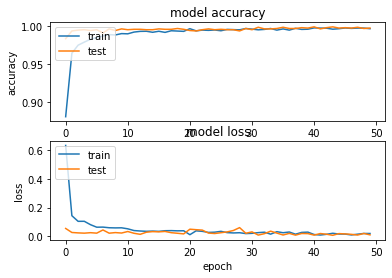

In [14]:
train_FC_model()

In [0]:

import PyPDF2
import os
import tensorflow
import sys
from tensorflow import keras
from keras.models import load_model
#import numpy as np
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Dense, Activation, Dropout, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import cv2


In [0]:
def process_img(img):
    img = img.resize((150, 150))  # resize the image
    img = np.array(img)
    #img = img / np.max(img).astype(float)
    img = np.reshape(img, [1, 150, 150, 3])
    return img

In [0]:
def predict(image_path):
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('class_indices.npy',allow_pickle=True).item()

    num_classes = len(class_dictionary)

    #load and pre-process the image
    #orig = cv2.imread(image_path)
    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # Rescale the image, this is important, otherwise the predictions will be '0'
    # This is because ImageDataGenerator set rescale=1. / 255, 
    # which means all data is re-scaled from a [0 - 255] range to [0 - 1.0]
    image = image / 255
    image = np.expand_dims(image, axis=0)

    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top FC model block
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #model.add(Dense(num_classes, activation='sigmoid'))  # to get class prediction
    model.add(Dense(num_classes, activation='softmax'))   # to get probability prediction
    
    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the FC model to get the final classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    #proba = model.predict_proba(bottleneck_prediction)
    
    output_y = model.predict(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Prediction: class ID: {}, Label: {}".format(inID, label))
    
    #print(proba)
    
    predict1 = {}
    for i in range(len(output_y[0])):
        predict1[inv_map[i]] = output_y[0][i]

    print(predict1)

    print('sum of probability = {0}'.format(sum(output_y[0])))
    
    

    # display the predictions with the image
    '''
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    '''

In [0]:
def Enter_Required_Data():

    Message1 = "Enter PDF Source Path (End with /,Example: C:/User/Admin/Documents/):"
    Message2 = "Enter PDF name (Example: Henry.pdf)"
    print(Message1)
    pdf_source = input()
    print(Message2)
    File_Name = input()
    return File_Name, pdf_source

In [0]:
def Pdf_data_Extractor(File_Name, pdf_source):

    Png_conversion_Script = "/content/drive/My Drive/Splitter"
    Pdf_Source_File_Name = pdf_source + File_Name

    reader = PyPDF2.PdfFileReader(Pdf_Source_File_Name)
    writer = PyPDF2.PdfFileWriter()

    File_Name = File_Name.split('.')[0]
    #os.mkdir(pdf_source+"Temp")
    Total_Number_of_Pages = reader.getNumPages()
    for Pg_No in range(0,Total_Number_of_Pages):
        Temporary_Directory = pdf_source + "Temp/" + File_Name+str(Pg_No)
        writer.addPage(reader.getPage(Pg_No))
        Command = "{} -f {} -l {} {} {}".format(Png_conversion_Script, Pg_No+1, Pg_No+1, Pdf_Source_File_Name, Temporary_Directory)
        #os.system(Command)
        print(Command)
    return writer,Total_Number_of_Pages

In [0]:
def prediction_And_Bookmark(writer,Total_Number_of_Pages, source_name, file_name):

    CATEGORIES = os.listdir('/content/drive/My Drive/TBird/DOCS/train')

    #basil 21-10
    #basil 21/10
    #for g in range(0, int(11)):
        #print(CATEGORIES[g])
        #writer.ad  dBookmark(CATEGORIES[g])
    CATEGORIT=[]
    for g in range(0, int(13)):
        if (g<12):

            #CATEGORIT.insert(g,CATEGORIES[g])
            CATEG =writer.addBookmark(CATEGORIES[g], 0, color=(1,0,0), bold=True)
            CATEGORIT.append(CATEG)
           # print(CATEGORIT)

            #os.mkdir(source_name+"CATEGO/"+CATEGORIES[g])
        else:
            #print("MISC DOCS")
            # parent = writer.addBookmark(CATEGORIES[g], 0, bold=True
            PARENT = writer.addBookmark("MISC DOCS", 0,color=(0,0,0), bold=True)



            #os.mkdir(source_name + "CATEGO/" + "MISC DOCS")
   # paren = os.listdir(parent)
    #PARENT = print(PARENTO)
    #PARENT=PARENTO.toString()+PARENTS.toString()
    #print(PARENT)

    #List_of_images.sort()
    #print("Prediction Code Running-0",Img)
    #for Page_No, Img in List_of_images:
    List_of_images = os.listdir(source_name+"/Temp/")
    List_of_images.sort()
    for Page_No, Img in enumerate(List_of_images):
        ###############################################
        """Prediction Code Here
                 returns pos"""

        test_image = Image.open(source_name+"/Temp/"+Img)
        test_image = process_img(test_image)
        prediction = predict(test_image)
        print(prediction, Img)
        pos = -1
        count = 0
        maximum = max(prediction[0])

        for i in range(0, len(prediction[0])):
            if maximum == prediction[0][i]:
                pos = i
                count = count + 1
            elif maximum * 0.222 < prediction[0][i]:
                count = count + 1
        if count > 1:
            print("Not Found")

            writer.addBookmark("Not Found",Page_No, parent=PARENT)

        else:
            print(CATEGORIES[pos])
            writer.addBookmark(CATEGORIES[pos], Page_No, parent=CATEGORIT[pos])

    sys.setrecursionlimit(2000)
    with open(source_name+file_name.split(".")[0]+"ReBookmarked.pdf","wb") as out:
        writer.write(out)

In [0]:
def Remove_Temp_Files(pdf_source):
   for x in os.listdir(pdf_source+"Temp"):
       os.remove(pdf_source+"Temp/"+x)
   os.removedirs(pdf_source+"Temp")
    #os.removedirs(pdf_source+"Temp")
   print("Removed Temp Folder")

In [0]:
def main():
    File_Name, pdf_source = Enter_Required_Data()
    Source_Name = pdf_source + File_Name

    writer, Total_Number_of_Pages = Pdf_data_Extractor(File_Name, pdf_source)

    prediction_And_Bookmark(writer, Total_Number_of_Pages, pdf_source,File_Name)

    #Remove_Temp_Files(pdf_source)

In [40]:
from skimage.io import imread
if __name__ == "__main__":
  main()

Enter PDF Source Path (End with /,Example: C:/User/Admin/Documents/):
/content/drive/My Drive/IP_PDF/
Enter PDF name (Example: Henry.pdf)
BENEFIEL.pdf
/content/drive/My Drive/Splitter -f 1 -l 1 /content/drive/My Drive/IP_PDF/BENEFIEL.pdf /content/drive/My Drive/IP_PDF/Temp/BENEFIEL0
/content/drive/My Drive/Splitter -f 2 -l 2 /content/drive/My Drive/IP_PDF/BENEFIEL.pdf /content/drive/My Drive/IP_PDF/Temp/BENEFIEL1
/content/drive/My Drive/Splitter -f 3 -l 3 /content/drive/My Drive/IP_PDF/BENEFIEL.pdf /content/drive/My Drive/IP_PDF/Temp/BENEFIEL2
/content/drive/My Drive/Splitter -f 4 -l 4 /content/drive/My Drive/IP_PDF/BENEFIEL.pdf /content/drive/My Drive/IP_PDF/Temp/BENEFIEL3
/content/drive/My Drive/Splitter -f 5 -l 5 /content/drive/My Drive/IP_PDF/BENEFIEL.pdf /content/drive/My Drive/IP_PDF/Temp/BENEFIEL4
/content/drive/My Drive/Splitter -f 6 -l 6 /content/drive/My Drive/IP_PDF/BENEFIEL.pdf /content/drive/My Drive/IP_PDF/Temp/BENEFIEL5
/content/drive/My Drive/Splitter -f 7 -l 7 /content

AttributeError: ignored

In [0]:
# add the path to your test image below
image_path = './data/Document_PNG/validation/Bank Statement/Chase-bank-statement-2.png'
predict(image_path)

#cv2.destroyAllWindows()

In [42]:
from tensorflow.compat.v1 import keras

# add the path to your test image below
image_path = '/content/drive/My Drive/TBird/DOCS/train/1003/BALDWIN1-000002.png'
predict(image_path)

#cv2.destroyAllWindows()

[INFO] loading and preprocessing image...


RuntimeError: ignored